In [5]:
import Junction
import random
import numpy as np
import os
import matplotlib.pyplot as plt
from collections import deque
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import InputLayer
from keras.optimizers import RMSprop
from keras.models import Sequential
import torch
import torch.nn as nn
import tensorflow as tf
from time import sleep
from keras.backend import tensorflow_backend as K

class DQNAgent(object):
    def __init__(self, frame_size, action_size, train):
        self.frame_size = frame_size
        self.action_size = action_size

        self.discount_factor = 0.99
        self.learning_rate = 0.000025
        self.epsilon = 1.0 if train else 0.0001  
        self.epsilon_decay = 0.9999 if train else 1.0
        self.epsilon_min = 0.02 if train else self.epsilon
        self.train_start = 500  # 500 episode의 경험이 쌓이기 전에는 train을 시작하지 않음
        self.batch_size = 128

        self.memory = deque(maxlen=1000000) 

        self.model = self.build_model()
        self.target_model = self.build_model()
        self.update_target_model()

        # 모델 구성
    def build_model(self):
        model = Sequential()
        model.add(Flatten(input_shape=(8,3)))
        model.add(Dense(32,
                        input_dim=self.frame_size,
                        activation="relu"))
        model.add(Dense(64,
                        activation="relu"))
        model.add(Dense(128,
                         activation="relu"))
        model.add(Dense(self.action_size,
                        activation="linear"))
        model.compile(loss="mse", optimizer=RMSprop(lr=self.learning_rate))
        return model
    # full connected layer, loss = mse, optimizer = adam


    # 위에서 구한 model의 weight로 target model 업데이트
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    # weight값 외부 파일로 저장 혹은 불러오기
    def load_model(self, path_to_model):
        if os.path.exists(path_to_model):
            self.model.load_weights(path_to_model)
            self.update_target_model()

    def save_model(self, path_to_model):
        self.model.save_weights(path_to_model)

    def get_action(self, state):
        if np.random.rand() <= self.epsilon:  # exploration
            return random.randrange(self.action_size)
        else:
            q_values = self.model.predict(state)
            return np.argmax(q_values[0])

    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def train_model(self):
        if len(self.memory) < self.train_start:
            return  # not enough experiences yet
        batch_size = min(self.batch_size, len(self.memory))
        mini_batch = random.sample(self.memory, batch_size)  # deque의 값을 랜덤하게 batch에 저장

        states = []
        next_states = []
        # make input for dnn
        for s, a, r, n, t in mini_batch:
            states.append(s[0])
            next_states.append(n[0])

        states = np.array(states)
        next_states = np.array(next_states)

        target = self.model.predict(states)
        qhat = self.target_model.predict(next_states)

        for i, experience in enumerate(mini_batch):
            s, a, r, n, t = experience  # (state, action, reward, next_state, done)
            if t:
                target[i][a] = r
            else:
                target[i][a] = r + self.discount_factor * (np.amax(qhat[i]))  # DQN

        self.model.fit(states, target, batch_size=batch_size, epochs=1, verbose=0)

    def update_epsilon(self, episode, step):
        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)


def reshape_state(state):
    return np.expand_dims(state, axis=0)


def plot_scores(scores):
    plt.plot(scores)
    plt.ylabel("Scores")
    plt.xlabel("Episodes")
    plt.plot()
    plt.savefig("./rewards.png")
    plt.show()
    
def plot_steps(steps):
    plt.scatter(list(range(len(steps))), steps, s=2)
    plt.ylabel("Steps")
    plt.xlabel("Episodes")
    plt.plot()
    plt.savefig("./steps.png")
    plt.show()


def run(total_episodes=1000,
                 save_weights_interval=50,
                 weights_path="./weight.h5",
                 train=True,
                 target_update_episode_interval=20,
                 stop_average_score=-1):
    frame_size = 24
    action_size = 8
    # 환경 설정

    agent = DQNAgent(frame_size, action_size, train)
    agent.load_model(weights_path)
    scores = []
    steps = []
    mva_score = 0
    env = Junction.Junction()
    
    for episode in range(total_episodes):
        done = False
        env = Junction.Junction() 
        state = env.get_state()
        state = reshape_state(state)
        score = 0
        step = 0
        while not done:
            

            step += 1
            action = agent.get_action(state)
            next_state, reward, done = env.step(action)
            next_state = reshape_state(next_state)
            

            if train:
                agent.append_sample(state, action, reward, next_state, done)
                agent.update_epsilon(episode, step)
            agent.train_model()
            score += reward
#             print(env.render())
#             sleep(0.3)
            state = next_state


        # episode is done
        steps.append(env.time)
        if train:
#             agent.train_model()
            if episode > 0 and episode % target_update_episode_interval == 0:
                agent.update_target_model()
            scores.append(score)
            mva_score = mva_score * 0.9 + score * 0.1 if len(scores) > 5 else np.average(scores)
            # 큰 의미는 없음
            


        if episode % 100 == 0:
            print("Game over: {} / step: {} / score: {} / average_score: {:.5f} / epsilon: {:.5f}".format(episode,
                                                                                                          step,
                                                                                                          score,
                                                                                                          mva_score,
                                                                                                  agent.epsilon))

            plot_scores(scores)
            plot_steps(steps)

        if episode > 0 and episode % save_weights_interval == 0:
            agent.save_model(weights_path)
        if 0 < stop_average_score <= mva_score:
            break

Game over: 0 / step: 101 / score: 100.36730006935613 / average_score: 0.00000 / epsilon: 0.00100


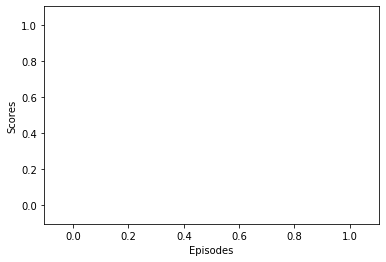

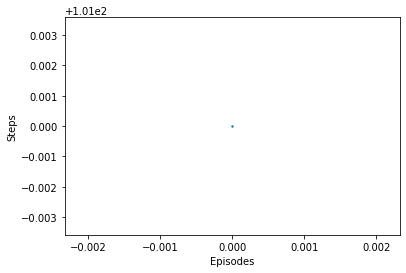

In [ ]:
if __name__ == "__main__":
    run(train=False,
        total_episodes=100000,
        save_weights_interval=1000,
        target_update_episode_interval=50,
        stop_average_score=-1,
        weights_path="./weight.h5")